In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

In [2]:
DISPOSAL_FILEPATH = "../../data/raw/council_disposal_receipts.xlsx"

YEAR_SKIP_MAPPING = {
    "2014": 0,
    "2015": 0,
    "2016": 2,
    "2017": 3,
    "2018": 3,
    "2019": 4,
    "2020": 4,
    "2021": 4,
    "2022": 4,
    "2023": 4,
}

dfs = []
for year, skip_row in YEAR_SKIP_MAPPING.items():
    df = pd.read_excel(DISPOSAL_FILEPATH, skiprows=skip_row, sheet_name=year)
    dfs.append(df)

dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')

In [3]:
def clean_sheet(df, rename_from_col=3, header_row=1):
    """
    Cleans a DataFrame read from Excel:
    - Replaces values in `header_row` with column names starting from `rename_from_col`
    - Keeps all columns up to `rename_from_col`
    - Keeps only renamed columns after `rename_from_col`
    - Sets row `header_row` as the header and drops all rows above it
    """
    # Step 1: Identify renamed columns
    renamed_mask = [not str(col).startswith("Unnamed:") for col in df.columns]

    # Step 2: Determine which columns to keep
    cols_to_keep = list(range(rename_from_col + 1))  # Always keep up to and including `rename_from_col`
    for i in range(rename_from_col + 1, len(df.columns)):
        if renamed_mask[i]:
            cols_to_keep.append(i)

    # Step 3: Overwrite header_row with column names for renamed columns
    for i in range(rename_from_col, len(df.columns)):
        if renamed_mask[i]:
            df.iloc[header_row, i] = df.columns[i]

    # Step 4: Set row `header_row` as header and drop rows above
    df.columns = df.iloc[header_row]
    df = df.drop(index=list(range(header_row + 1))).reset_index(drop=True)

    # Step 5: Keep only selected columns
    df = df.iloc[:, cols_to_keep]

    return df

def rename_and_filter_disposal(df, start_col=5, keyword=": Disposal of tangible fixed assets"):
    """
    Keeps:
    - All columns before `start_col`
    - Columns from `start_col` onward that contain `keyword`
    
    Renames matching columns by removing the keyword from their name.
    """
    cols_to_keep = list(range(start_col))  # Keep early columns as-is

    new_columns = df.columns.tolist()  # Copy of column names

    for i in range(start_col, len(df.columns)):
        col = str(df.columns[i])
        if keyword in col:
            # Rename column by removing the keyword
            new_columns[i] = col.replace(keyword, "")
            cols_to_keep.append(i)

    # Apply renaming
    df.columns = new_columns

    # Keep only selected columns
    return df.iloc[:, cols_to_keep]

dfs[0] = clean_sheet(dfs[0], rename_from_col=3, header_row=1)
dfs[1] = clean_sheet(dfs[1], rename_from_col=4, header_row=1)
dfs[2] = clean_sheet(dfs[2], rename_from_col=4, header_row=2)
dfs[3] = clean_sheet(dfs[3], rename_from_col=5, header_row=0)
dfs[4] = clean_sheet(dfs[4], rename_from_col=5, header_row=0)

dfs[5] = rename_and_filter_disposal(dfs[5], start_col=5)
dfs[6] = rename_and_filter_disposal(dfs[6], start_col=5)
dfs[7] = rename_and_filter_disposal(dfs[7], start_col=5)
dfs[8] = rename_and_filter_disposal(dfs[8], start_col=5)
dfs[9] = rename_and_filter_disposal(dfs[9], start_col=6)

In [4]:
for i in range(10):
    df = dfs[i]

    # Step 1: Standardise column names first
    df.columns = df.columns.str.strip().str.lower()
    if 'la name' in df.columns:
        df = df.rename(columns={'la name': 'local_authority'})
    
    if 'local_authority' in df.columns:
        df['local_authority'] = df['local_authority'].str.replace(r'(?i)\(ua\)|\bua\b', '', regex=True).str.strip()

    # Step 2: Drop bad values in first column
    first_col = df.columns[0]
    df = df[~df[first_col].isin([pd.NA, None, '[z]', 'la_lgf_code'])]
    df = df.dropna(subset=[first_col])

    # Step 3: Drop missing ONS codes
    if i == 0 and 'ecode' in df.columns:
        df = df.dropna(subset=['ecode'])
    elif i != 0 and 'ons code' in df.columns:
        df = df.dropna(subset=['ons code'])

    # Step 4: Drop unwanted council classes
    if 'class' in df.columns:
        df = df[~df['class'].isin(['O'])] #'SC'

    # Save cleaned frame back
    dfs[i] = df

In [5]:
merge_columns = {
    "community safety": ["community safety", "community safety (cctv)"],
    'agricultural & fisheries services':['agriculture & fisheries'],
    'all services total':['total all services'],
    'early years & primary schools':['pre-primary & primary education'],
    'parking':['parking of vehicles'],
    'ports & piers':['local authority ports & piers'],
    'special schools & alternative provision':['special education'],
    'secondary schools':['secondary education'],
    'total industrial & commercial trading':['industrial & commercial trading'],
    'total environmental & regulatory services':['total environmental services','regulatory services (environmental health)'],
    'tolled roads, bridges, tunnels,ferries & public transport companies':['tolled road bridges, tunnels, ferries, public transport companies','tolled road bridges, tunnels, ferries & public transport companies'],
    'public transport (bus)':['public passenger transport - bus'],
    'public transport (rail & other)':['public passenger transport - rail & other'],
    'total housing':['housing'],
    'total police':['police'],
    'total social care':['social services','social care'],
    'total public health':['public health'],
    'roads, street lighting & road safety':['roads, street lights & safety'],
    'total fire & rescue services':['fire & rescue services'],
    'total central services':['central services (including court services)'],
    'street cleaning (not chargeable to highways)':['street cleaning not chargeable to highways'],
    'total planning & development':['total planning & development services','planning & development services'],
    'total trading services':['total trading','trading'],
    'total education':['education'],
    'total highways & transport':['total transport','highways & transport'],
    'total culture & related services':['culture & heritage']

    #'commercial housing',
    #'energy generation & supply',
    #'finance & insurance activity',
    #'hospitality & catering',
    #'lgf code',
    #'ons code',
    #'other commercial activity',
    #'other real estate activities',
    #'post-16 provision & other education',
    #'subclass',
    #'total digital infrastructure',
    #'water supply, sewerage & remediation'
}

# Standardise and merge alias columns across all dfs
for idx in range(len(dfs)):
    df = dfs[idx].copy()
    df.columns = [
        str(col).strip().lower()
        .replace(" and ", " & ")
        for col in df.columns
    ]

    dfs[idx] = df  # Save the cleaned version

    for standard_col, aliases in merge_columns.items():
        # Find which alias columns are present
        present_cols = [col for col in aliases if col in df.columns]
        if not present_cols:
            continue  # Nothing to merge for this category

        # Sum across all present columns
        df[standard_col] = df[present_cols].sum(axis=1, skipna=True)

        # Drop duplicates, except the one we’re keeping
        cols_to_drop = [col for col in present_cols if col != standard_col]
        df.drop(columns=cols_to_drop, inplace=True)

    dfs[idx] = df  # Save the cleaned DataFrame back

In [6]:
years = list(range(2014, 2024))

# Step 1: Add year column
for i, year in enumerate(years):
    dfs[i]['financial_year'] = year

# Step 2: Concatenate all years
full_df = pd.concat(dfs, ignore_index=True)

# Step 3: Melt to long-form: category, value
id_vars = ['ecode', 'local_authority', 'class', 'financial_year']
value_vars = [col for col in full_df.columns if col not in id_vars]

long_df = pd.melt(full_df, id_vars=id_vars, value_vars=value_vars,
                  var_name='category', value_name='value')

# Optional: convert 'value' to numeric
long_df['value'] = pd.to_numeric(long_df['value'], errors='coerce')


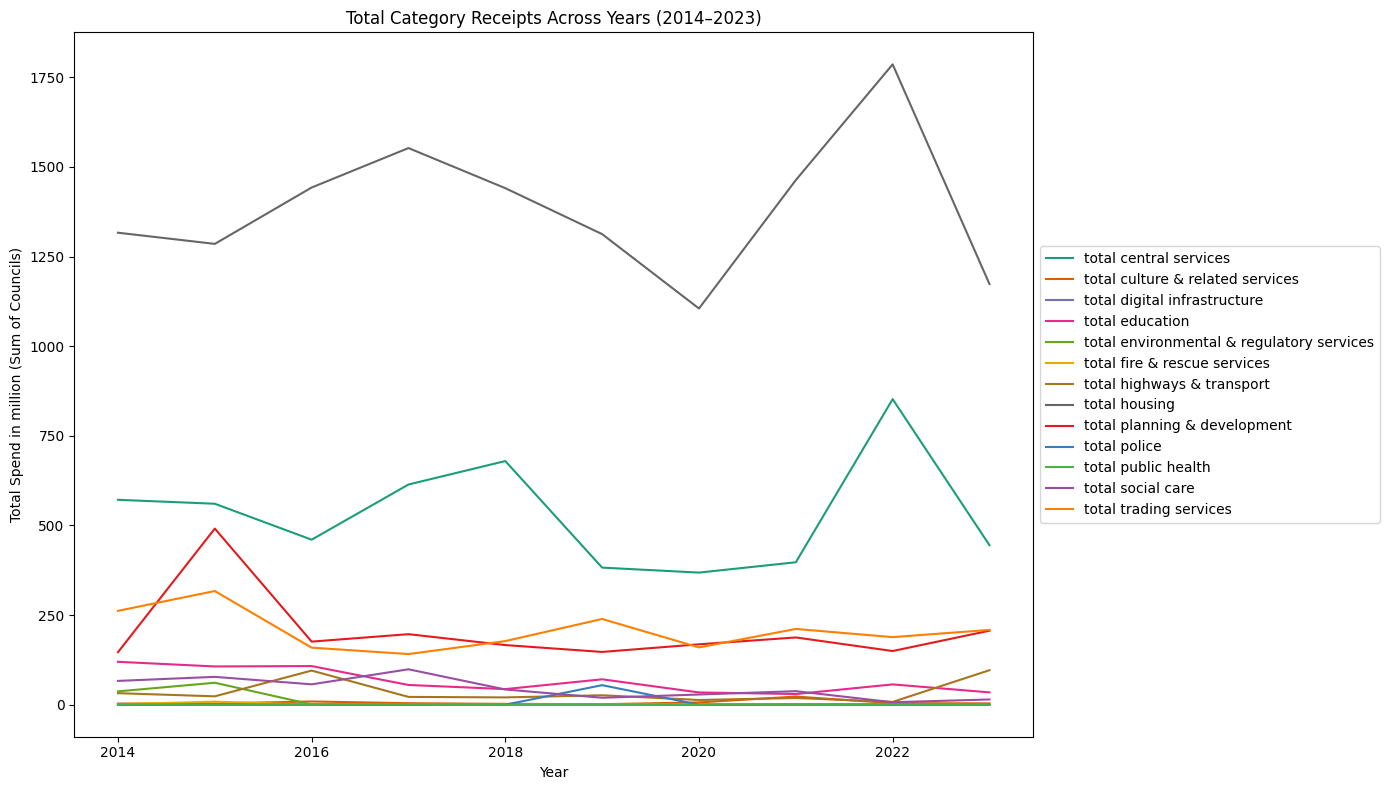

In [8]:
# Step 1: Group and sum from long_df
grouped_df = (
    long_df[
        long_df['category'].str.startswith('total') &
        ~long_df['category'].str.contains(', of which', case=False) &
        (long_df['category'].str.lower() != 'total industrial & commercial trading')
    ]
    .groupby(['financial_year', 'category'])['value']
    .sum()
    .reset_index()
)

grouped_df['value'] = pd.to_numeric(grouped_df['value'], errors='coerce')/1000
# Step 2: Pivot for plotting
pivot_df = grouped_df.pivot(index='financial_year', columns='category', values='value')

plt.figure(figsize=(14, 8))

# Combine multiple dark colormaps
dark_colors = np.vstack([
    plt.cm.Dark2(np.linspace(0, 1, 8)),
    plt.cm.Set1(np.linspace(0, 1, 9))
])

colors = dark_colors[:len(pivot_df.columns)]  # Clip to number of categories

for idx, col in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index, pivot_df[col], label=col, color=colors[idx])

plt.xlabel('Year')
plt.ylabel('Total Spend in million (Sum of Councils)')
plt.title('Total Category Receipts Across Years (2014–2023)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


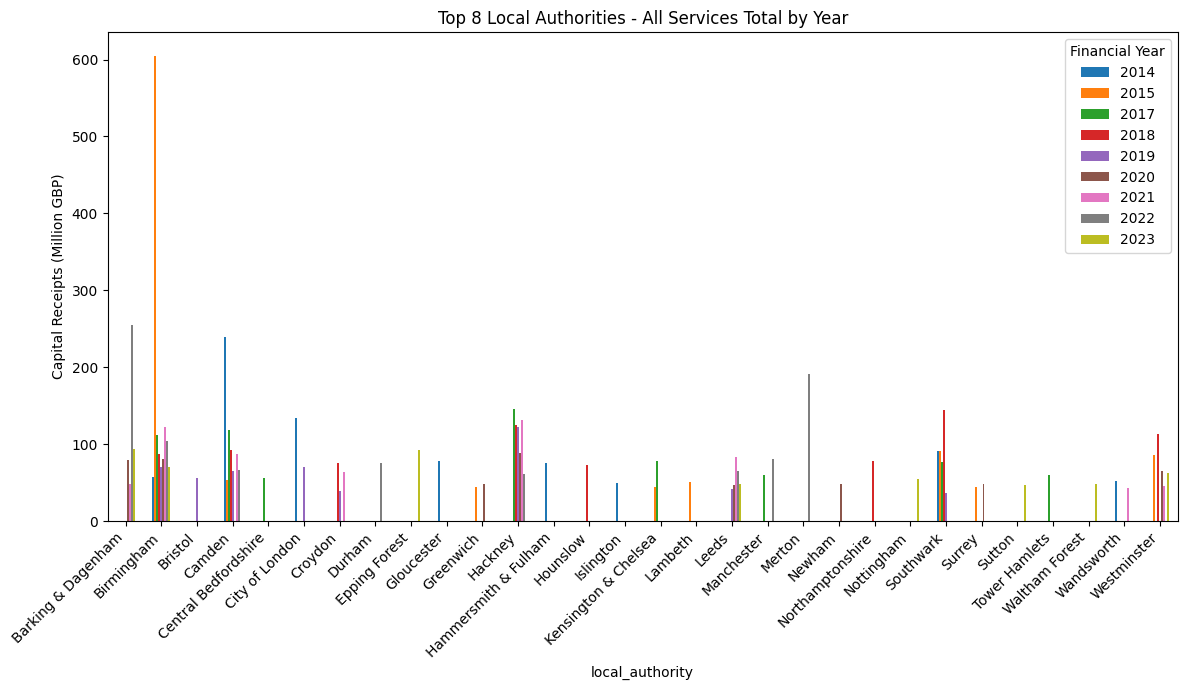

In [9]:
# Filter All Services Total
filtered_df = long_df[
    (long_df['category'].str.lower() == 'all services total') & 
    (long_df['value'].notna())
].copy()

# Convert value to million
filtered_df['value'] = pd.to_numeric(filtered_df['value'], errors='coerce') / 1_000

# Group and find top 5 councils per year
top5_per_year = (
    filtered_df.groupby(['financial_year', 'local_authority'])['value']
    .sum()
    .reset_index()
    .sort_values(['financial_year', 'value'], ascending=[True, False])
    .groupby('financial_year')
    .head(8)
)

# Pivot the table for plotting
pivot_top5 = top5_per_year.pivot(index='local_authority', columns='financial_year', values='value')

# Plotting
pivot_top5.plot(kind='bar', figsize=(12, 7))

plt.ylabel('Capital Receipts (Million GBP)')
plt.title('Top 8 Local Authorities - All Services Total by Year')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Financial Year')
plt.tight_layout()
plt.show()



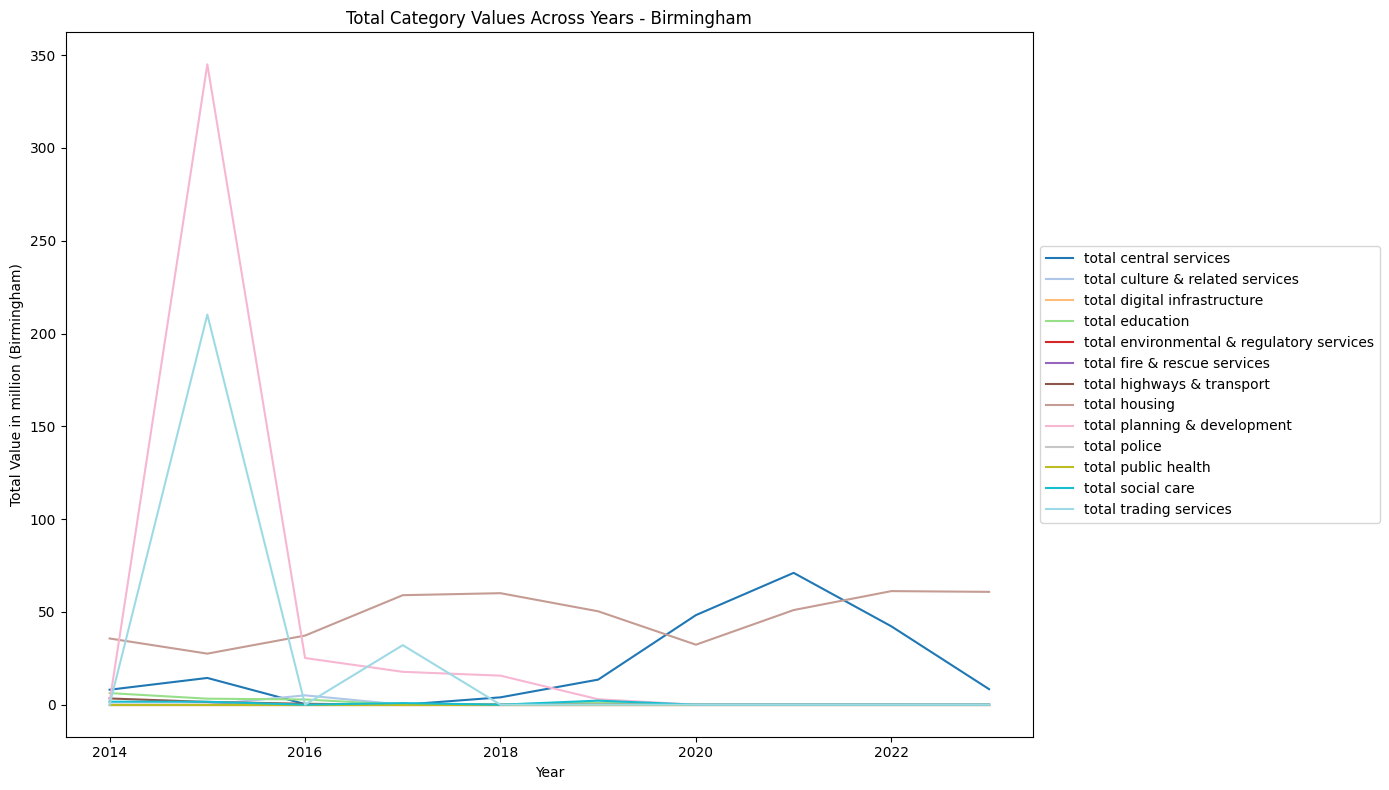

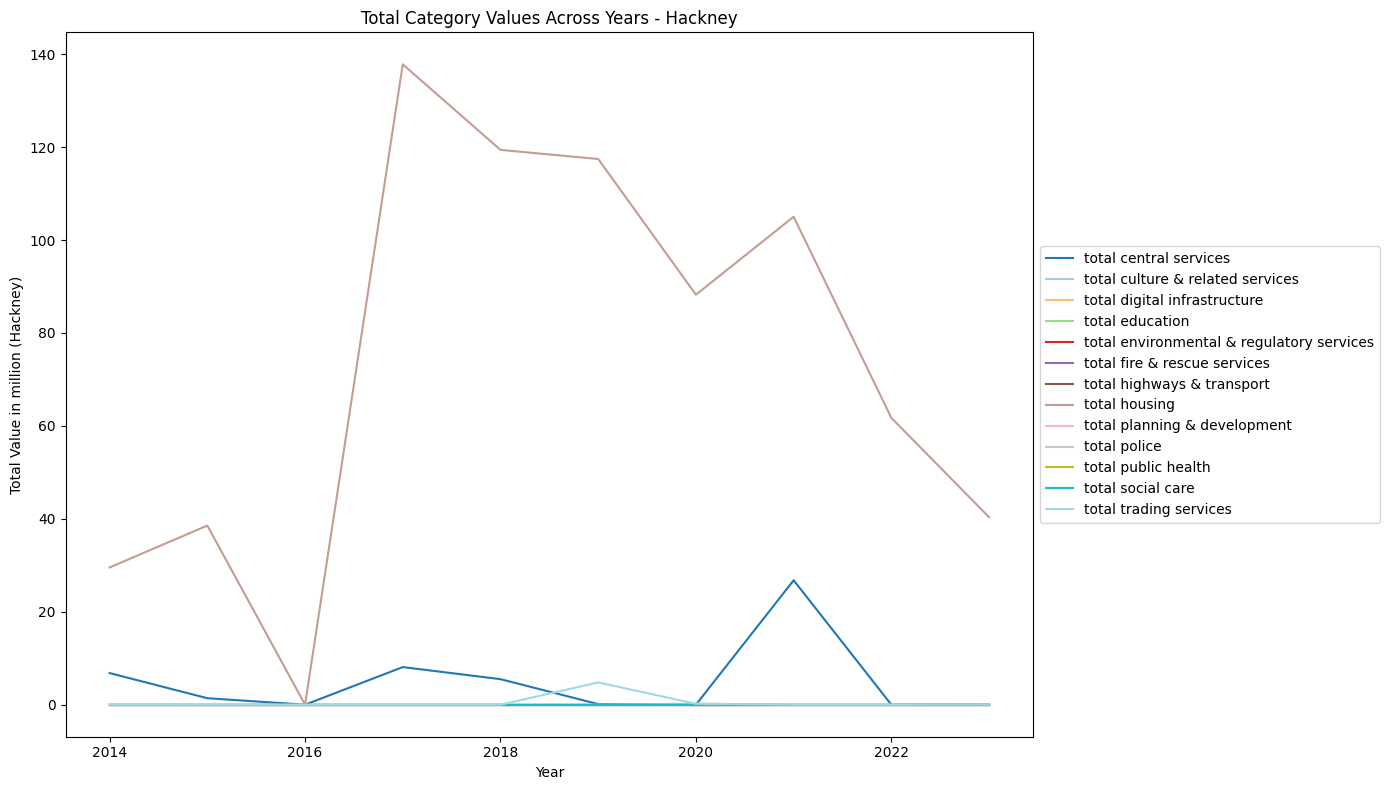

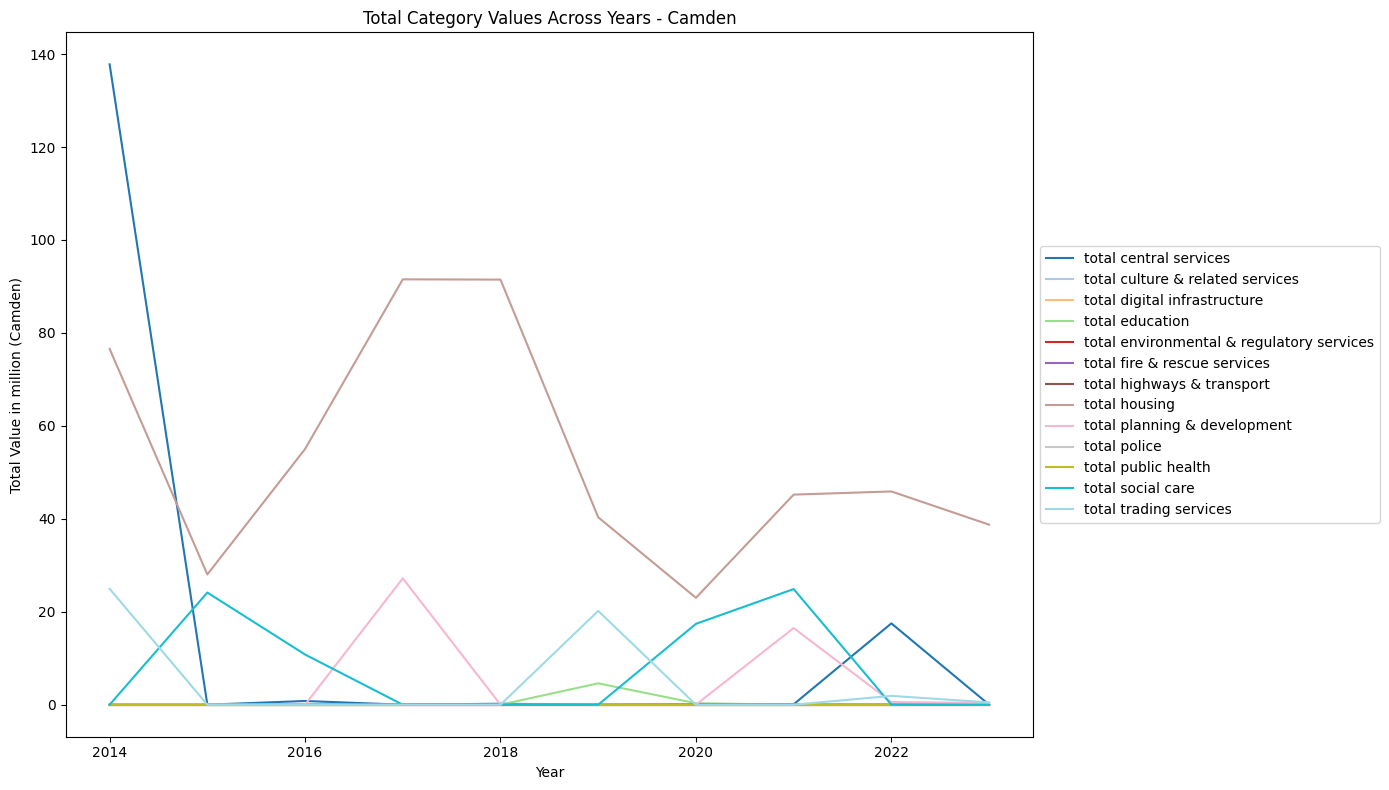

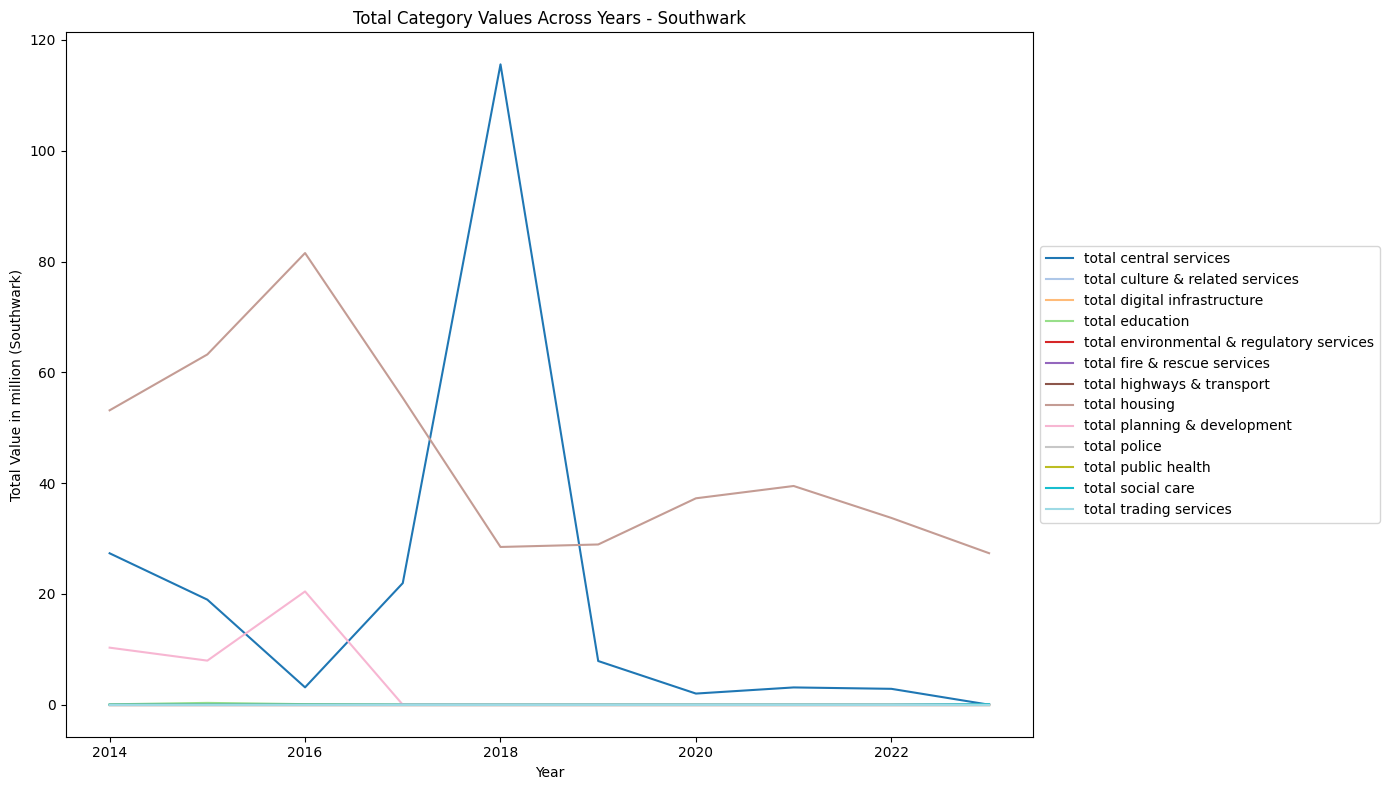

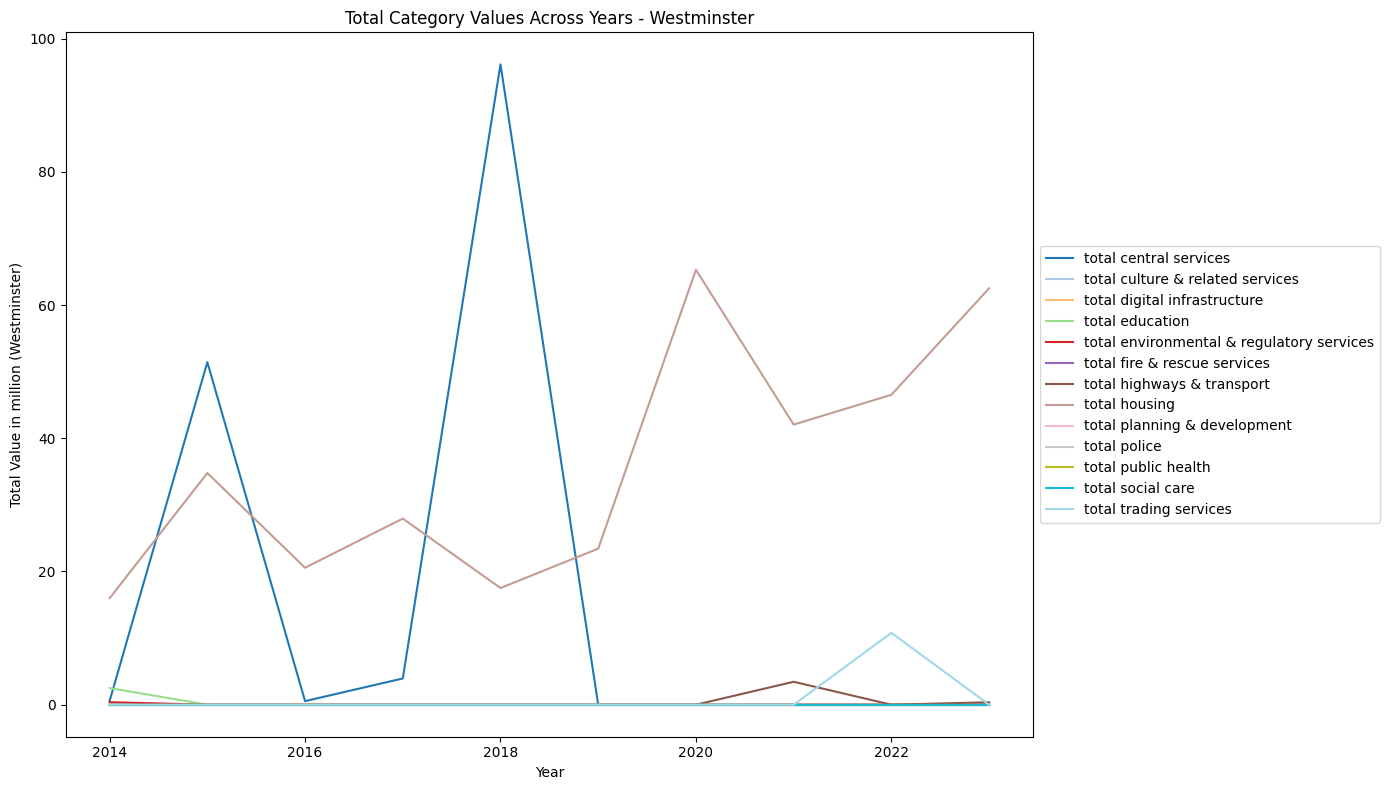

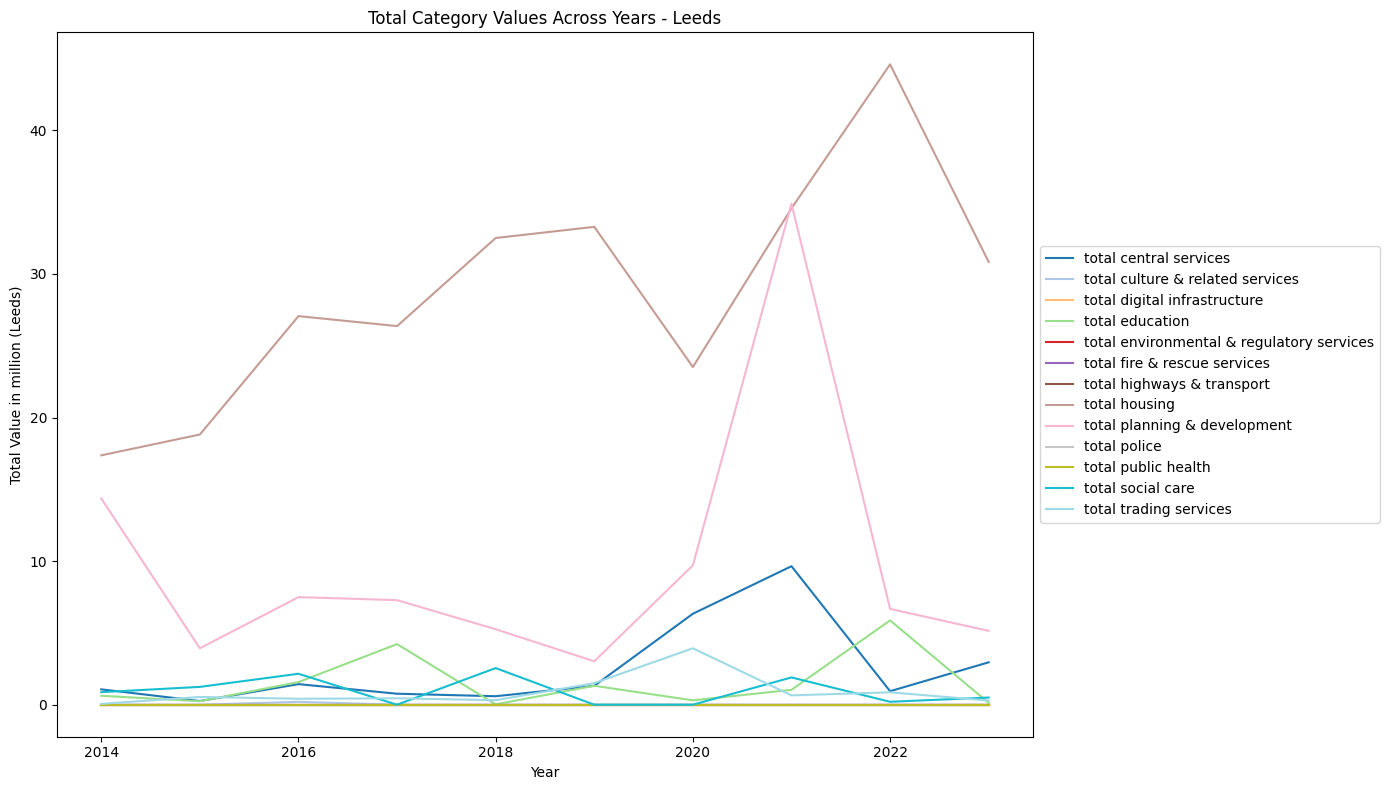

In [20]:
# Function to generate and plot for any local authority
def plot_local_authority_trends(local_authority_name):
    df = long_df[
        (long_df['local_authority'].str.lower() == local_authority_name.lower()) &
        (long_df['category'].str.startswith('total')) &
        ~long_df['category'].str.contains(', of which', case=False) &
        (long_df['category'].str.lower() != 'total industrial & commercial trading')
    ].copy()

    grouped = (
        df.groupby(['financial_year', 'category'])['value']
        .sum()
        .reset_index()
    )

    grouped['value'] = pd.to_numeric(grouped['value'], errors='coerce') / 1000

    pivot = grouped.pivot(index='financial_year', columns='category', values='value')

    plt.figure(figsize=(14, 8))
    colors = plt.cm.tab20(np.linspace(0, 1, len(pivot.columns)))

    for idx, col in enumerate(pivot.columns):
        plt.plot(pivot.index, pivot[col], label=col, color=colors[idx])

    plt.xlabel('Year')
    plt.ylabel(f'Total Value in million ({local_authority_name.title()})')
    plt.title(f'Total Category Values Across Years - {local_authority_name.title()}')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

# Generate plots for Camden, Southwark, Westminster, Leeds
for la in ['Birmingham', 'Hackney', 'Camden', 'Southwark', 'Westminster', 'Leeds']:
    plot_local_authority_trends(la)

